In [2]:
from google.colab import userdata
import os

api_key = userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

os.environ["OPENAI_API_BASE"] = "https://api.aimlapi.com/v1"

In [3]:
!pip install -q langchain langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 1.5 MB/s eta 0:00:00


In [5]:
!apt-get install graphviz -y
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [10]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableSequence, RunnableLambda, RunnableParallel
from graphviz import Digraph

In [11]:
# Model & prompt
model = ChatOpenAI(model="gpt-4o-mini")
prompt = ChatPromptTemplate.from_template("Write a haiku about {topic}.")
parser = StrOutputParser()

# RunnableSequence
seq = RunnableSequence(first=prompt, middle=[model], last=parser)

# Preprocessing lambda
preprocess = RunnableLambda(lambda x: {"topic": x["topic"].upper()})

# Full single sequence chain
single_chain = preprocess | seq

# Parallel chains
branch1 = RunnableLambda(lambda x: seq.invoke(x))
branch2 = RunnableLambda(lambda x: seq.invoke(x))
parallel_chain = RunnableParallel({"branch1": branch1, "branch2": branch2})

In [12]:
def draw_sequence_graph(chain, filename="sequence_graph"):
    dot = Digraph(comment="RunnableSequence Graph")

    nodes = []
    # Flatten the chain into nodes
    if isinstance(chain, RunnableSequence):
        if chain.first: nodes.append(("first", chain.first.__class__.__name__))
        for i, mid in enumerate(chain.middle):
            nodes.append((f"middle{i}", mid.__class__.__name__))
        if chain.last: nodes.append(("last", chain.last.__class__.__name__))
    elif isinstance(chain, RunnableLambda):
        nodes.append(("lambda", chain.__class__.__name__))

    # Add nodes
    for node_id, label in nodes:
        dot.node(node_id, label)

    # Add edges
    for i in range(len(nodes)-1):
        dot.edge(nodes[i][0], nodes[i+1][0])

    # Save & render
    dot.render(filename, format="png", view=True)
    print(f"Graph saved to {filename}.png")

In [13]:
draw_sequence_graph(single_chain, filename="single_sequence")

Graph saved to single_sequence.png


In [16]:
def draw_parallel_graph(parallel_chain, filename="parallel_graph"):
    from graphviz import Digraph

    dot = Digraph(comment="RunnableParallel Graph")

    # Access branches via _dict__steps (internal attribute in current LangChain)
    # If you’re using a newer version, you may need to inspect dir(parallel_chain)
    if hasattr(parallel_chain, "steps__"):
        branches = parallel_chain.steps__  # dictionary of branch_name -> Runnable
    else:
        raise ValueError("Cannot access branches in this RunnableParallel version")

    for branch_name, runnable in branches.items():
        with dot.subgraph(name=f"cluster_{branch_name}") as c:
            c.attr(label=branch_name)
            if isinstance(runnable, RunnableLambda):
                c.node(branch_name, runnable.__class__.__name__)
            elif isinstance(runnable, RunnableSequence):
                nodes = []
                if runnable.first: nodes.append(("first", runnable.first.__class__.__name__))
                for i, mid in enumerate(runnable.middle):
                    nodes.append((f"middle{i}", mid.__class__.__name__))
                if runnable.last: nodes.append(("last", runnable.last.__class__.__name__))
                for node_id, label in nodes:
                    c.node(f"{branch_name}_{node_id}", label)
                for i in range(len(nodes)-1):
                    c.edge(f"{branch_name}_{nodes[i][0]}", f"{branch_name}_{nodes[i+1][0]}")

    dot.render(filename, format="png", view=True)
    print(f"Parallel graph saved to {filename}.png")

In [17]:
draw_parallel_graph(parallel_chain, filename="parallel_sequence")

Parallel graph saved to parallel_sequence.png


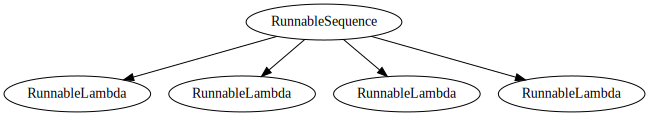

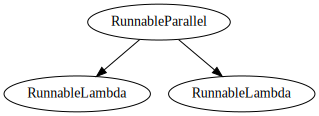

In [19]:
from graphviz import Digraph
from langchain.schema.runnable import RunnableSequence, RunnableLambda, RunnableParallel

def visualize_chain(chain, graph=None, parent=None, name="root"):
    if graph is None:
        graph = Digraph(comment="LangChain Graph")

    node_label = type(chain).__name__
    graph.node(name, node_label)

    if parent:
        graph.edge(parent, name)

    if isinstance(chain, RunnableSequence):
        # Add first
        if chain.first:
            visualize_chain(chain.first, graph, parent=name, name=name+"_first")
        # Add middle
        for i, mid in enumerate(chain.middle):
            visualize_chain(mid, graph, parent=name, name=f"{name}_mid{i}")
        # Add last
        if chain.last:
            visualize_chain(chain.last, graph, parent=name, name=name+"_last")

    elif isinstance(chain, RunnableParallel):
        # Access branches via steps__ (internal dict)
        branches = getattr(chain, "steps__", {})
        for branch_name, branch_runnable in branches.items():
            visualize_chain(branch_runnable, graph, parent=name, name=f"{name}_{branch_name}")

    return graph

# --- Example chains ---
# Single sequence
single_chain = RunnableLambda(lambda x: x) | RunnableSequence(first=RunnableLambda(lambda x: x),
                                                              middle=[RunnableLambda(lambda x: x)],
                                                              last=RunnableLambda(lambda x: x))
# Parallel chain
branch1 = RunnableLambda(lambda x: x)
branch2 = RunnableLambda(lambda x: x)
parallel_chain = RunnableParallel({"branch1": branch1, "branch2": branch2})

# --- Generate and display graphs ---
graph1 = visualize_chain(single_chain)
graph2 = visualize_chain(parallel_chain)

display(graph1)
display(graph2)